<a href="https://colab.research.google.com/github/tangshuting/daytoy/blob/master/VTcnn2_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pickle
import numpy as np
from scipy import integrate
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=cuda,floatX=float32"
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras

In [4]:
from google.colab import drive
drive.mount('/content/drive')
f = open(r'/content/drive/My Drive/EMW/2016.04C.multisnr.pkl','rb') #open的参数是pkl文件的路径
Xd = pickle.load(f,encoding='bytes')
print(type(Xd))   # dict
print(len(Xd))  #220=11（类别）×20（20个snr）
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])  # set()创建一个无序的不重复元素序列
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr)) # append末尾添加对象
X = np.vstack(X)
print(X.shape)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
<class 'dict'>
220
(162060, 2, 128)


In [5]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size= int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
# changed from x to combined data
# X_train = combined_Data[train_idx]
# X_test =  combined_Data[test_idx]
X_train = X[train_idx]
X_test =  X[test_idx]
print(X_train.shape)

(81030, 2, 128)


In [6]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods

print(Y_train[1])
print(Y_train.shape)
print(classes)

(81030, 2, 128) [2, 128]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(81030, 11)
[b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']


In [9]:
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns

dr = 0.3 # dropout rate (%)
model = models.Sequential()
in_shp = [2, 128]
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 2, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform')) 
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense(11, init='he_normal', name="dense2" ))
model.add(Activation('relu'))
model.add(Dense(11,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 2, 132, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 130, 256)       1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 130, 256)       0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 2, 134, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 132, 80)        122960    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 132, 80)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), activation="relu", name="conv1", padding="valid", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), activation="relu", name="conv2", padding="valid", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, name="dense2", kernel_initializer="he_normal")`


In [10]:
# Set up some params
nb_epoch = 100    # number of epochs to train on
batch_size = 1024  # training batch size

# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'CNN2_adv.wts.h5'
history=model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_split=0.05,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)



Train on 76978 samples, validate on 4052 samples
Epoch 1/100
 - 17s - loss: 2.4201 - accuracy: 0.1508 - val_loss: 2.2638 - val_accuracy: 0.1483
Epoch 2/100
 - 17s - loss: 2.1173 - accuracy: 0.2181 - val_loss: 1.9743 - val_accuracy: 0.2601
Epoch 3/100
 - 17s - loss: 1.8868 - accuracy: 0.2916 - val_loss: 1.7604 - val_accuracy: 0.3487
Epoch 4/100
 - 17s - loss: 1.6428 - accuracy: 0.3681 - val_loss: 1.4822 - val_accuracy: 0.4319
Epoch 5/100
 - 17s - loss: 1.4254 - accuracy: 0.4465 - val_loss: 1.3135 - val_accuracy: 0.5158
Epoch 6/100
 - 17s - loss: 1.3049 - accuracy: 0.5016 - val_loss: 1.2291 - val_accuracy: 0.5281
Epoch 7/100
 - 17s - loss: 1.2285 - accuracy: 0.5309 - val_loss: 1.1619 - val_accuracy: 0.5545
Epoch 8/100
 - 17s - loss: 1.1639 - accuracy: 0.5558 - val_loss: 1.0944 - val_accuracy: 0.5864
Epoch 9/100
 - 17s - loss: 1.1188 - accuracy: 0.5715 - val_loss: 1.0508 - val_accuracy: 0.5874
Epoch 10/100
 - 17s - loss: 1.0726 - accuracy: 0.5878 - val_loss: 1.0136 - val_accuracy: 0.6071


In [11]:
score = model.evaluate(X_test, Y_test, batch_size=batch_size)
print(model.metrics_names)
print (score)

81030/81030 [==============================] - 5s 66us/step
['loss', 'accuracy']
[0.9325897399766878, 0.6392200589179993]


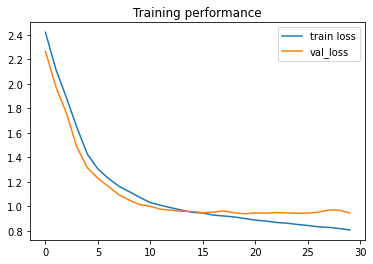

In [12]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.legend()

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

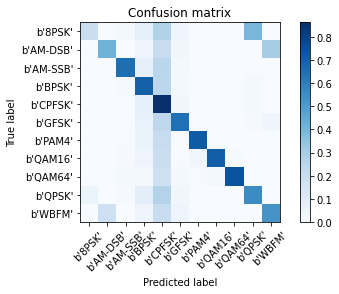

In [14]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes), len(classes)])
confnorm = np.zeros([len(classes), len(classes)])
for i in range(0, X_test.shape[0]):
    j = list(Y_test[i, :]).index(1)
    k = int(np.argmax(test_Y_hat[i, :]))
    conf[j, k] = conf[j, k] + 1
for i in range(0, len(classes)):
    confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.1555445298933267
Overall Accuracy:  0.152863111329565
Overall Accuracy:  0.15927021696252466
Overall Accuracy:  0.16198757763975155
Overall Accuracy:  0.19134010643444604
Overall Accuracy:  0.2975165970002459
Overall Accuracy:  0.47979426891991184
Overall Accuracy:  0.6636229022704837
Overall Accuracy:  0.7561160151324086
Overall Accuracy:  0.8747225647348952
Overall Accuracy:  0.8629932985852569
Overall Accuracy:  0.8642310540607258
Overall Accuracy:  0.9031865726100705
Overall Accuracy:  0.9366370808678501
Overall Accuracy:  0.8362788414334806
Overall Accuracy:  0.8963474827245804
Overall Accuracy:  0.9198511166253102
Overall Accuracy:  0.8510585305105853
Overall Accuracy:  0.8943089430894309
Overall Accuracy:  0.9392430278884463


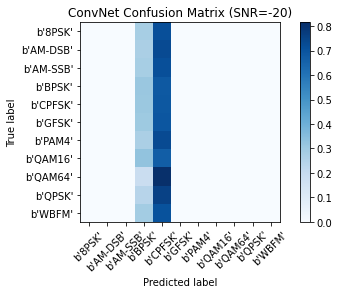

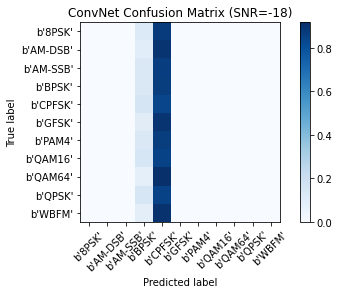

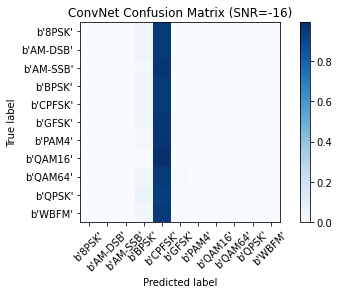

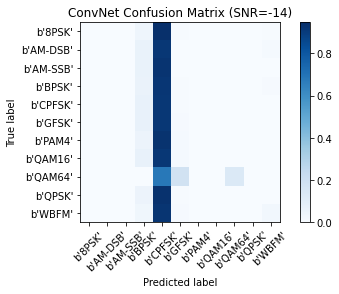

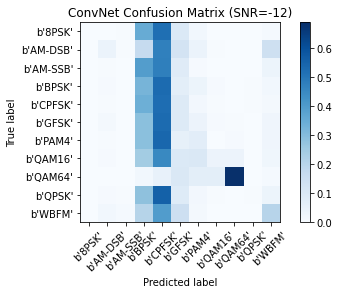

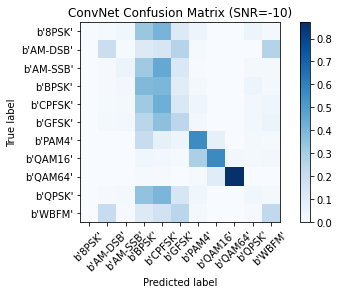

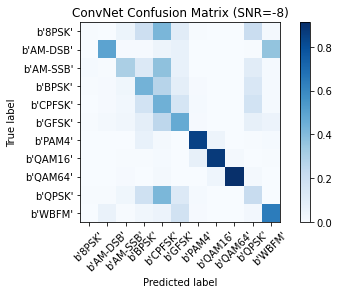

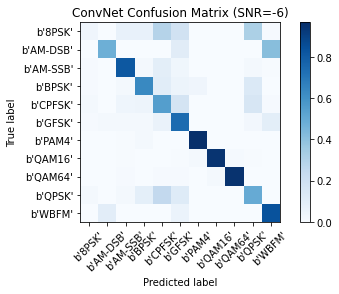

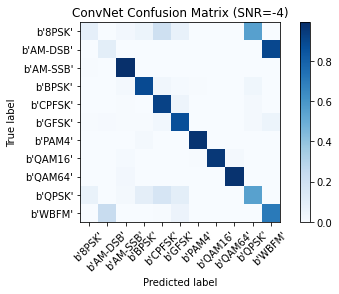

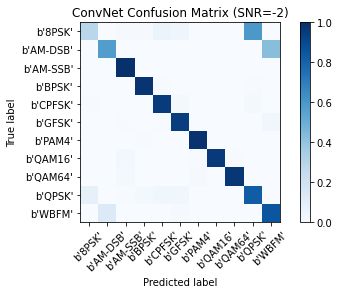

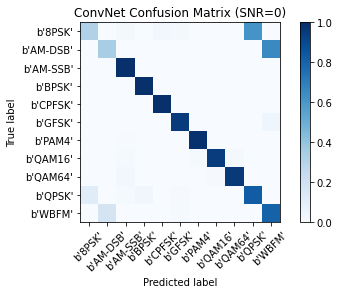

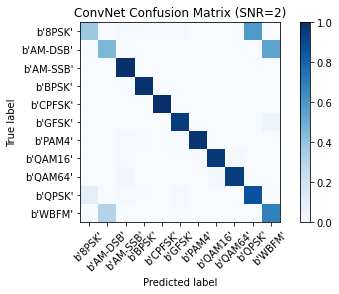

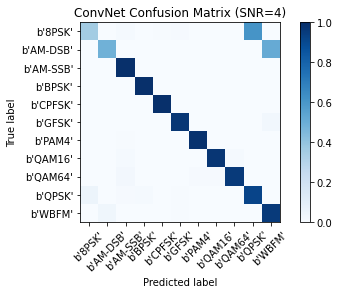

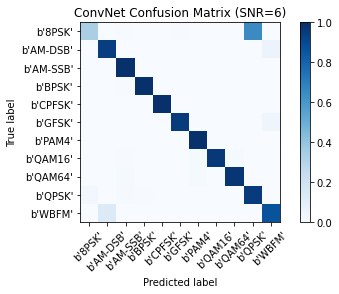

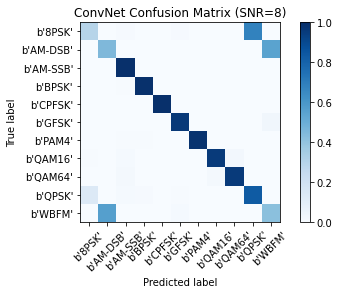

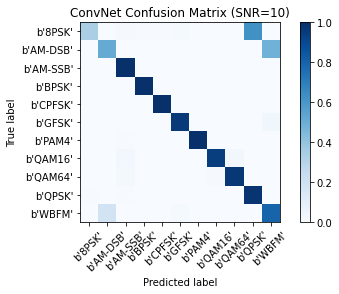

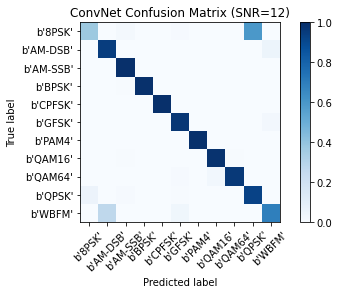

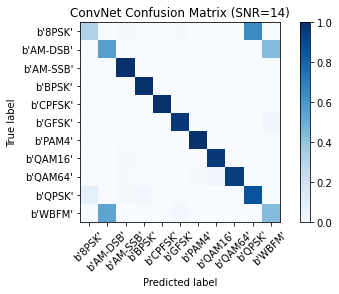

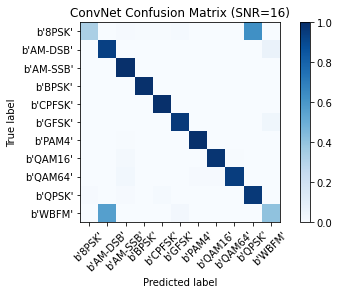

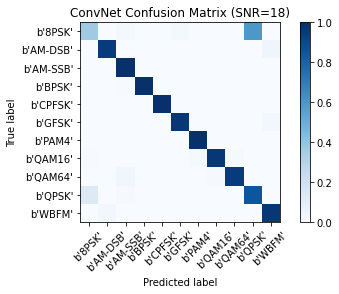

In [15]:
acc = {}
# eps = 0.2
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs) == snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])

    # loss=keras.losses.categorical_crossentropy(test_Y_i,model.output)

    # gradient=K.gradients(loss,model.input)

    # sign_grad = K.sign(gradient[0])
    # adv = test_X_i + eps*sign_grad

    for i in range(0, test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)" % (snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor + ncor))
    acc[snr] = 1.0 * cor / (cor + ncor)

Text(0, 0.5, 'Classification Accuracy')

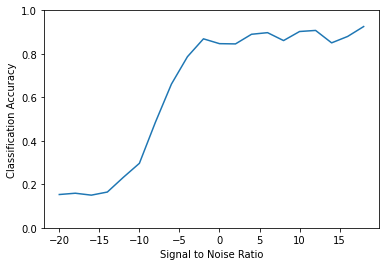

In [0]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.ylim(0, 1)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")